In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from Models import LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import math
import plotly.express as px
import plotly.graph_objects as go


In [2]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler


/home/ambekar/anaconda3/envs/rpy/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
import rpy2
import rpy2.robjects
from rpy2.robjects.packages import importr

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

TsAD = importr('otsad')
TSdist = importr('TSdist')

In [3]:
import sys
import os
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Importing local modules (statistical distance measures)
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from WassersteinDistance import Wasserstein_Dist
from DTS_Distance import DTS_Dist # Combo of Anderson_Darling and CVM distance.

In [5]:
nb_dir

'/home/ambekar/Thesis/SafeML_Exp/TimeSeriesSafeML/Experiments/Implementation_in_Python'

In [8]:
from ecdf_tensor.ecdf_distance_measures import WassersteinDistance

In [9]:
wd = WassersteinDistance()   

Load and Prepare data to input to LSTM model

In [10]:
filepath = "RELIANCE_2010-01-012021-08-30.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

Date    Open    High      Low    Close    Volume      Name
0  2010-01-04  1091.1  1091.1  1021.85  1075.50  17520006  RELIANCE
1  2010-01-05  1149.9  1149.9  1065.40  1070.70   4890040  RELIANCE
2  2010-01-06  1079.9  1094.5  1070.65  1088.00   5415538  RELIANCE
3  2010-01-07  1088.0  1115.0  1078.00  1106.05   5988404  RELIANCE
4  2010-01-08  1108.0  1113.8  1096.00  1103.15   3453926  RELIANCE

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [12]:
def splitData(ts):

    test_set_size = int(np.round(0.2*len(ts)))
    train_set = ts[:-test_set_size]    
    test_set = ts[-test_set_size:]

    return train_set, test_set


In [13]:
def modify_test_data(test_set, mean, variance):
    
    noise = np.random.normal(mean, variance, len(test_set))
    modified_test_Set = test_set + noise

    return modified_test_Set

In [14]:
train_set, test_set = splitData(data['Close'].values)

In [15]:
#Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

In [16]:
# Normalize the training, validation and test set

def normalize_data(train_set, test_set):
    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
    test_norm = scaler.transform(test_set.reshape(-1, 1))
    
    return train_norm, test_norm

In [17]:
window_size = 20
def prepareDataForTraining(seq):

    x_data = []
    y_data = []
    L = len(seq)
    for i in range(L-window_size):        
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+1]
        x_data.append(window)
        y_data.append(label)
    return x_data, y_data    

In [18]:
train_norm, test_norm = normalize_data(train_set, test_set)
train_norm, test_norm = normalize_data(train_set, test_set)

x_train, y_train = prepareDataForTraining(train_norm)
x_test, y_test = prepareDataForTraining(test_norm)

x_train = np.asarray(x_train).reshape(-1, window_size, 1)
y_train = np.asarray(y_train).reshape(-1, 1)
x_test = np.asarray(x_test).reshape(-1, window_size, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

In [19]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

x_train.shape =  (2296, 20, 1)
y_train.shape =  (2296, 1)
x_test.shape =  (559, 20, 1)
y_test.shape =  (559, 1)


In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='closing price'))

fig.update_yaxes(range=[500, 2500])

In [21]:
num_clusters = 7

In [22]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=num_clusters,                          
                          metric="dtw",                          
                          max_iter_barycenter=10,
                          random_state=23)

#without normalization
# y_pred = dba_km.fit(x_train_cluster) : Only displays the cluster centres (in red) and the training data is not assigned to any cluster as 
# predict(train) is not done.

y_pred = dba_km.fit_predict(x_train)

DBA k-means


In [23]:
sz = x_train.shape[1]
sz

20

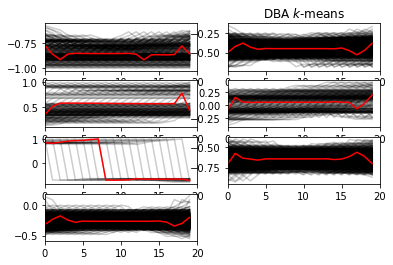

In [20]:
for yi in range(num_clusters):
    plt.subplot(4, 2, 1 + yi)
    for xx in x_train[y_pred == yi]:
        plt.plot(xx.flatten(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    if yi == 1:
        plt.title("DBA $k$-means")

In [21]:
mean = []
cluster_std = []
cluster_var = []


for i in range(num_clusters):

    cluster = x_train[y_pred == i]
    cluster = np.array(cluster)
    
    mean.append(np.mean(cluster))

    cluster =  np.array(cluster)

    std = np.std(cluster, axis=1)
    var = np.var(cluster, axis=1)

    std = std.flatten()
    var = var.flatten()

    std_max_index = np.argmax(std)
    std_max = std.max()

    var_max_index = np.argmax(var)
    var_max = var.max()

    cluster_std.append(std_max)
    cluster_var.append(var_max)    
    

stats = pd.DataFrame({'mean': mean,
                    'standard deviation': cluster_std,
                    'variance': cluster_var

})

clusters = [i for i in range(num_clusters)]

stats.insert(0, 'clusters', clusters)
stats.set_index('clusters', inplace=True)


In [22]:
stats

mean  standard deviation  variance
clusters                                        
0        -0.841231            0.090157  0.008128
1        -0.445122            0.108287  0.011726
2         0.511264            0.149101  0.022231
3         0.055918            0.212500  0.045156
4         0.093621            0.778527  0.606104
5        -0.642993            0.109032  0.011888
6        -0.263760            0.139618  0.019493

In [23]:
mean = []
std = []
var = []


for i in range(num_clusters):

    cluster = dba_km.cluster_centers_[i]

    mean.append(np.mean(cluster))
    std.append(np.std(cluster))
    var.append(np.var(cluster, dtype=np.float64))
    

stats_centroid = pd.DataFrame({'centroid mean': mean,
                    'centroid standard deviation': std,
                    'centroid variance': var

})

clusters = [i for i in range(num_clusters)]

stats_centroid.insert(0, 'clusters', clusters)
stats_centroid.set_index('clusters', inplace=True)


In [24]:
stats_centroid

centroid mean  centroid standard deviation  centroid variance
clusters                                                               
0             -0.854018                     0.031667           0.001003
1             -0.449602                     0.031683           0.001004
2              0.559415                     0.075593           0.005714
3              0.053535                     0.058203           0.003388
4             -0.050339                     0.778360           0.605845
5             -0.641371                     0.031621           0.001000
6             -0.263746                     0.034687           0.001203

In [24]:
model = torch.load('lstm_model.pt')
model.eval()

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [30]:
# input_dim = 1
# hidden_dim = 32
# num_layers = 2
# output_dim = 1
# num_epochs = 100

# model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
# criterion = torch.nn.MSELoss(reduction='mean')
# optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# hist = np.zeros(num_epochs)
# lstm = []

# for t in range(num_epochs):
#     y_train_pred = model(x_train)

#     loss = criterion(y_train_pred, y_train_lstm)
#     hist[t] = loss.item()

#     optimiser.zero_grad()
#     loss.backward()
#     optimiser.step()
    


In [26]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_test_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')
print('RMSE: ', rmse)

Test Score: 0.05 MAPE
R-squared value is 0.8867951845393981
RMSE:  123.6272315584738


#### Predict the cluster for forecast data

In [27]:
#apply transformation to forecasts as it was applied to train set
preds_norm = scaler.transform(y_test_pred[:,0].reshape(-1, 1))
preds_inv = scaler.inverse_transform(preds_norm)

loop = len(y_test_pred) - window_size + 1 

forecasts = []

for i in range(loop):        
    window = preds_norm[i:i+window_size]
    forecasts.append(window)  

forecasts = np.asarray(forecasts).reshape(-1, window_size, 1)

In [28]:
res = dba_km.predict(forecasts)

In [66]:
res

array([2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [67]:
np.where(res == 6)

(array([190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200]),)

In [29]:
forecasts_df = pd.DataFrame({'forecasts': preds_inv.flatten(),
                            'gt': y_test[:,0]})
forecasts_df.head()

forecasts           gt
0  1320.032715  1313.050049
1  1312.546997  1329.750000
2  1315.232300  1330.150024
3  1320.791992  1360.200073
4  1337.419067  1351.649902

In [69]:
forecasts_df.tail()

forecasts           gt
554  1970.841309  2162.349854
555  1970.364624  2183.699951
556  1974.531738  2202.600098
557  1982.029053  2230.449951
558  1993.057861  2227.399902

In [70]:
len(forecasts_df)

559

In [71]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=forecasts_df.index, y=forecasts_df['gt'], mode='lines', name='gt'))
fig.add_trace(go.Scatter(x=forecasts_df.index, y=forecasts_df['forecasts'], mode='lines', name='forecasts'))


In [30]:
def get_statistical_dist_measures(X1, X2):   

    CVM_distance = Cramer_Von_Mises_Dist(X1, X2)
    Anderson_Darling_distance = Anderson_Darling_Dist(X1, X2)
    Kolmogorov_Smirnov_distance = Kolmogorov_Smirnov_Dist(X1, X2)
    Kuiper_distance = Kuiper_Dist(X1, X2)
    Wasserstein_distance = Wasserstein_Dist(X1, X2)
    DTS_distance = DTS_Dist(X1, X2)   
    
    # Returning dictionary, for efficient and fast DataFrame creation. Returns mean for each distance.
    # See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.
    # PRESERVE THE ORDERING
    return {'Anderson_Darling_dist': Anderson_Darling_distance,
            'CVM_dist': CVM_distance,
            'DTS_dist':DTS_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Kuiper_dist': Kuiper_distance,
            'Wasserstein_dist': Wasserstein_distance}

#### Compute mean relative change for different test sequences

In [33]:
t = [130, 184, 244, 225, 160, 235, 175, 30, 264, 380]
mean = []
std = []
var = []
cluster_assigned = []
cluster_mean = []

distances_all = []


for i in t:

    data = np.array(forecasts[i])

    mean.append(np.mean(data))
    # std.append(np.std(data))
    # var.append(np.var(data, dtype=np.float64))
    cluster_assigned.append(res[i])

    preds_inv = scaler.inverse_transform(data)
    cluster_inv = scaler.inverse_transform(dba_km.cluster_centers_[res[i]])
    

    distances = get_statistical_dist_measures(cluster_inv.flatten(), preds_inv.flatten())

    distances_all.append(distances)

    # cluster_mean.append(np.mean(dba_km.cluster_centers_[res[i]]))

tests = pd.DataFrame({'test values': t,
                    'mean': mean,                   
                    'cluster_assigned': cluster_assigned                   

})
distances_df = pd.DataFrame(distances_all)

result = pd.concat([tests, distances_df], axis=1)
    

In [34]:
result

test values      mean  cluster_assigned  Anderson_Darling_dist  CVM_dist  \
0          130  0.751102                 2               6.603119     18.45   
1          184  0.074694                 3               3.449505      8.55   
2          244  0.797008                 2               5.963496     16.60   
3          225  0.589746                 2               2.338969      6.25   
4          160  0.586227                 2               2.060413      5.45   
5          235  0.634754                 2               2.662427      6.95   
6          175  0.473327                 2               3.071150      7.95   
7           30  0.148281                 3               3.172500      8.35   
8          264  1.187532                 2               7.045834     19.75   
9          380  1.424809                 2               7.045834     19.75   

     DTS_dist  Kolmogorov_Smirnov_dist  Kuiper_dist  Wasserstein_dist  
0   35.034459                     0.95         0.95         93.002189  
1   59.251470                     0.50         0.90        140.575936  
2   46.595638                     0.85         0.85        115.385923  
3   11.766841                     0.40         0.65         22.396292  
4   10.760242                     0.45         0.70         23.529729  
5   19.865848                     0.50         0.75         44.387701  
6   23.579748                     0.45         0.80         52.459169  
7   18.922269                     0.60         0.75         50.411934  
8  104.442099                     1.00         1.00        305.419541  
9  138.364063                     1.00         1.00        421.336826

In [38]:
preds_inv = scaler.inverse_transform(forecasts[264])
cluster_inv = scaler.inverse_transform(dba_km.cluster_centers_[2])

In [39]:
wd._compute_distance(cluster_inv.flatten(), preds_inv.flatten())

305.4195413031379

In [73]:
preds_inv = scaler.inverse_transform(forecasts[0])
cluster_inv = scaler.inverse_transform(dba_km.cluster_centers_[2])
cluster_inv.flatten()

array([1330.97590988, 1411.80086413, 1444.20319756, 1443.77039671,
       1443.44439764, 1443.05879753, 1442.49359755, 1442.03479738,
       1441.37119732, 1440.54039722, 1439.93319706, 1439.37239694,
       1438.92199685, 1438.50159677, 1438.19679657, 1438.19679657,
       1438.21039652, 1438.23439642, 1542.5025007 , 1374.93465795])

In [75]:
preds_inv.flatten()

array([1320.0327, 1312.547 , 1315.2323, 1320.792 , 1337.4191, 1348.1602,
       1342.163 , 1326.9026, 1316.1626, 1315.7162, 1320.5369, 1323.3251,
       1320.218 , 1301.587 , 1284.1554, 1273.0332, 1276.8307, 1277.8452,
       1270.4585, 1276.6354], dtype=float32)

In [51]:
Wasserstein_Dist(cluster_inv.flatten(), preds_inv[0:20].flatten())

121.6323026220175

In [77]:
result

test values      mean  cluster_assigned  Anderson_Darling_dist  CVM_dist  \
0          130  0.751102                 2               6.603119     18.45   
1          184  0.074694                 3               3.449505      8.55   
2          244  0.797008                 2               5.963496     16.60   
3          225  0.589746                 2               2.338969      6.25   
4          160  0.586227                 2               2.060413      5.45   
5          235  0.634754                 2               2.662427      6.95   
6          175  0.473327                 2               3.071150      7.95   
7           30  0.148281                 3               3.172500      8.35   
8          264  1.187532                 2               7.045834     19.75   
9          380  1.424809                 2               7.045834     19.75   

     DTS_dist  Kolmogorov_Smirnov_dist  Kuiper_dist  Wasserstein_dist  
0   35.034459                     0.95         0.95         93.002189  
1   59.251470                     0.50         0.90        140.575936  
2   46.595638                     0.85         0.85        115.385923  
3   11.766841                     0.40         0.65         22.396292  
4   10.760242                     0.45         0.70         23.529729  
5   19.865848                     0.50         0.75         44.387701  
6   23.579748                     0.45         0.80         52.459169  
7   18.922269                     0.60         0.75         50.411934  
8  104.442099                     1.00         1.00        305.419541  
9  138.364063                     1.00         1.00        421.336826

In [79]:
# tests_mean = tests.copy()

In [80]:
# tests_mean['mean diff'] = (tests_mean['mean'] - tests_mean['cluster_mean'])
# tests_mean

test values      mean  standard deviation  variance  cluster_assigned  \
0          130  0.757815            0.052477  0.002754                 2   
1          184  0.077356            0.338947  0.114885                 3   
2          244  0.816088            0.151176  0.022854                 2   
3          225  0.593933            0.085164  0.007253                 2   
4          160  0.594790            0.086670  0.007512                 2   
5          235  0.641733            0.112858  0.012737                 2   
6          175  0.475399            0.165178  0.027284                 2   
7           30  0.153387            0.099002  0.009801                 3   
8          264  1.209300            0.125740  0.015811                 2   
9          380  1.475338            0.031657  0.001002                 2   

   cluster_mean  mean diff  
0      0.559415   0.198400  
1      0.053535   0.023822  
2      0.559415   0.256673  
3      0.559415   0.034518  
4      0.559415   0.035375  
5      0.559415   0.082318  
6      0.559415  -0.084016  
7      0.053535   0.099852  
8      0.559415   0.649885  
9      0.559415   0.915923

In [81]:
# tests_mean['mean relative change'] = tests_mean['mean diff'] / abs(tests_mean['cluster_mean'])
# tests_mean

test values      mean  standard deviation  variance  cluster_assigned  \
0          130  0.757815            0.052477  0.002754                 2   
1          184  0.077356            0.338947  0.114885                 3   
2          244  0.816088            0.151176  0.022854                 2   
3          225  0.593933            0.085164  0.007253                 2   
4          160  0.594790            0.086670  0.007512                 2   
5          235  0.641733            0.112858  0.012737                 2   
6          175  0.475399            0.165178  0.027284                 2   
7           30  0.153387            0.099002  0.009801                 3   
8          264  1.209300            0.125740  0.015811                 2   
9          380  1.475338            0.031657  0.001002                 2   

   cluster_mean  mean diff  mean relative change  
0      0.559415   0.198400              0.354657  
1      0.053535   0.023822              0.444974  
2      0.559415   0.256673              0.458824  
3      0.559415   0.034518              0.061705  
4      0.559415   0.035375              0.063236  
5      0.559415   0.082318              0.147151  
6      0.559415  -0.084016             -0.150186  
7      0.053535   0.099852              1.865184  
8      0.559415   0.649885              1.161724  
9      0.559415   0.915923              1.637288

<p> As there is an increase in the mean (trend) in data after 260th timestamp, the relative change in mean of forecast distribution is decreasing compared to that of relative change in mean of actual values. This difference here is computed based on shape and statistical properties of forecasts distributions. For these data points, the assigned clusters in actual values and forecasts is the same. </p>

We should check for data points, where the assigned clusters could be different.

(0.0, 20.0)

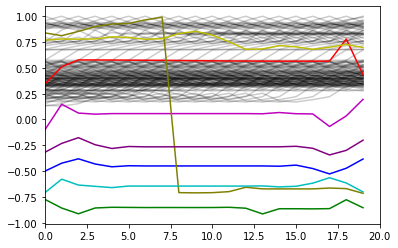

In [75]:
# plot forecasts[130]

for xx in x_train[y_pred == 2]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[2].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[0].ravel(), "g-")
plt.plot(dba_km.cluster_centers_[1].ravel(), "b-")
plt.plot(dba_km.cluster_centers_[3].ravel(), "m-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "olive")
plt.plot(dba_km.cluster_centers_[5].ravel(), "c")
plt.plot(dba_km.cluster_centers_[6].ravel(), "purple")
plt.plot(forecasts[130], "y-")
plt.xlim(0, sz)

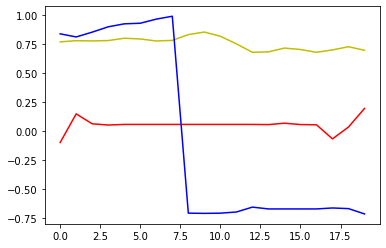

In [76]:
plt.plot(forecasts[130], "y-")
plt.plot(dba_km.cluster_centers_[3].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "b-")

(0.0, 20.0)

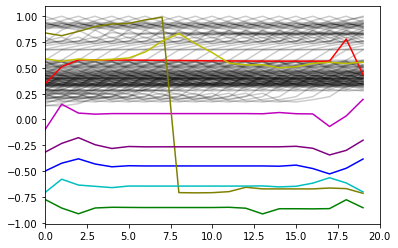

In [77]:
# plot forecasts[225]

for xx in x_train[y_pred == 2]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[2].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[0].ravel(), "g-")
plt.plot(dba_km.cluster_centers_[1].ravel(), "b-")
plt.plot(dba_km.cluster_centers_[3].ravel(), "m-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "olive")
plt.plot(dba_km.cluster_centers_[5].ravel(), "c")
plt.plot(dba_km.cluster_centers_[6].ravel(), "purple")
plt.plot(forecasts[225], "y-")
plt.xlim(0, sz)

(0.0, 20.0)

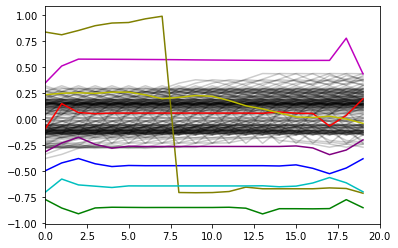

In [78]:
# plot forecasts[30]

for xx in x_train[y_pred == 3]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[3].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[0].ravel(), "g-")
plt.plot(dba_km.cluster_centers_[1].ravel(), "b-")
plt.plot(dba_km.cluster_centers_[2].ravel(), "m-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "olive")
plt.plot(dba_km.cluster_centers_[5].ravel(), "c")
plt.plot(dba_km.cluster_centers_[6].ravel(), "purple")
plt.plot(forecasts[30], "y-")
plt.xlim(0, sz)

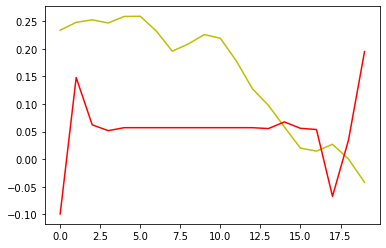

In [79]:
plt.plot(forecasts[30], "y-")
plt.plot(dba_km.cluster_centers_[3].ravel(), "r-")

(0.0, 20.0)

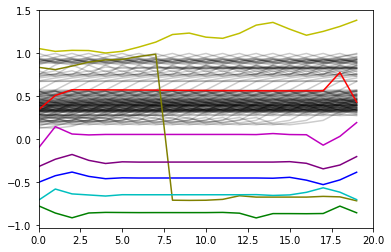

In [80]:
# plot forecasts[264] 

for xx in x_train[y_pred == 2]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[2].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[0].ravel(), "g-")
plt.plot(dba_km.cluster_centers_[1].ravel(), "b-")
plt.plot(dba_km.cluster_centers_[3].ravel(), "m-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "olive")
plt.plot(dba_km.cluster_centers_[5].ravel(), "c")
plt.plot(dba_km.cluster_centers_[6].ravel(), "purple")
plt.plot(forecasts[264], "y-")
plt.xlim(0, sz)

(0.0, 20.0)

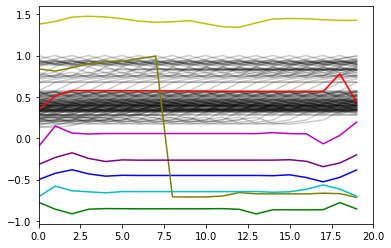

In [81]:
# plot forecasts[380]

for xx in x_train[y_pred == 2]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[2].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[0].ravel(), "g-")
plt.plot(dba_km.cluster_centers_[1].ravel(), "b-")
plt.plot(dba_km.cluster_centers_[3].ravel(), "m-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "olive")
plt.plot(dba_km.cluster_centers_[5].ravel(), "c")
plt.plot(dba_km.cluster_centers_[6].ravel(), "purple")
plt.plot(forecasts[380], "y-")
plt.xlim(0, sz)

#### Compute difference between maximum std of assigned cluster and various test sequences

In [82]:
tests_std_var = tests.copy()
tests_std_var

test values      mean  standard deviation  variance  cluster_assigned  \
0          130  0.757815            0.052477  0.002754                 2   
1          184  0.077356            0.338947  0.114885                 3   
2          244  0.816088            0.151176  0.022854                 2   
3          225  0.593933            0.085164  0.007253                 2   
4          160  0.594790            0.086670  0.007512                 2   
5          235  0.641733            0.112858  0.012737                 2   
6          175  0.475399            0.165178  0.027284                 2   
7           30  0.153387            0.099002  0.009801                 3   
8          264  1.209300            0.125740  0.015811                 2   
9          380  1.475338            0.031657  0.001002                 2   

   cluster_mean  
0      0.559415  
1      0.053535  
2      0.559415  
3      0.559415  
4      0.559415  
5      0.559415  
6      0.559415  
7      0.053535  
8      0.559415  
9      0.559415

In [83]:
for clustercentre in tests_std_var['cluster_assigned']:
    print(type(clustercentre))
    print(clustercentre)
    break

<class 'int'>
2


In [84]:
cluster_std = []
cluster_var = []

for clustercentre in tests_std_var['cluster_assigned']:

    cluster = x_train[y_pred == clustercentre]
    cluster =  np.array(cluster)

    std = np.std(cluster, axis=1)
    var = np.var(cluster, axis=1)

    std = std.flatten()
    var = var.flatten()

    std_max_index = np.argmax(std)
    std_max = std.max()

    var_max_index = np.argmax(var)
    var_max = var.max()

    cluster_std.append(std_max)
    cluster_var.append(var_max)

In [85]:
tests_std_var = tests_std_var.assign(**{'cluster std': cluster_std, 'cluster variance':cluster_var})
tests_std_var

test values      mean  standard deviation  variance  cluster_assigned  \
0          130  0.757815            0.052477  0.002754                 2   
1          184  0.077356            0.338947  0.114885                 3   
2          244  0.816088            0.151176  0.022854                 2   
3          225  0.593933            0.085164  0.007253                 2   
4          160  0.594790            0.086670  0.007512                 2   
5          235  0.641733            0.112858  0.012737                 2   
6          175  0.475399            0.165178  0.027284                 2   
7           30  0.153387            0.099002  0.009801                 3   
8          264  1.209300            0.125740  0.015811                 2   
9          380  1.475338            0.031657  0.001002                 2   

   cluster_mean  cluster std  cluster variance  
0      0.559415     0.149101          0.022231  
1      0.053535     0.212500          0.045156  
2      0.559415     0.149101          0.022231  
3      0.559415     0.149101          0.022231  
4      0.559415     0.149101          0.022231  
5      0.559415     0.149101          0.022231  
6      0.559415     0.149101          0.022231  
7      0.053535     0.212500          0.045156  
8      0.559415     0.149101          0.022231  
9      0.559415     0.149101          0.022231

In [86]:
tests_std_var['max std diff'] = (tests_std_var['standard deviation'] - tests_std_var['cluster std'])
tests_std_var['std reltive change'] = tests_std_var['max std diff'] / abs(tests_std_var['cluster std'])
tests_std_var

test values      mean  standard deviation  variance  cluster_assigned  \
0          130  0.757815            0.052477  0.002754                 2   
1          184  0.077356            0.338947  0.114885                 3   
2          244  0.816088            0.151176  0.022854                 2   
3          225  0.593933            0.085164  0.007253                 2   
4          160  0.594790            0.086670  0.007512                 2   
5          235  0.641733            0.112858  0.012737                 2   
6          175  0.475399            0.165178  0.027284                 2   
7           30  0.153387            0.099002  0.009801                 3   
8          264  1.209300            0.125740  0.015811                 2   
9          380  1.475338            0.031657  0.001002                 2   

   cluster_mean  cluster std  cluster variance  max std diff  \
0      0.559415     0.149101          0.022231     -0.096624   
1      0.053535     0.212500          0.045156      0.126447   
2      0.559415     0.149101          0.022231      0.002075   
3      0.559415     0.149101          0.022231     -0.063937   
4      0.559415     0.149101          0.022231     -0.062430   
5      0.559415     0.149101          0.022231     -0.036243   
6      0.559415     0.149101          0.022231      0.016077   
7      0.053535     0.212500          0.045156     -0.113498   
8      0.559415     0.149101          0.022231     -0.023360   
9      0.559415     0.149101          0.022231     -0.117444   

   std reltive change  
0           -0.648043  
1            0.595046  
2            0.013917  
3           -0.428818  
4           -0.418712  
5           -0.243074  
6            0.107828  
7           -0.534110  
8           -0.156675  
9           -0.787681

In [87]:
tests_std_var['max var diff'] = (tests_std_var['variance'] - tests_std_var['cluster variance'])
tests_std_var['var reltive change'] = tests_std_var['max var diff'] / abs(tests_std_var['cluster variance'])
tests_std_var

test values      mean  standard deviation  variance  cluster_assigned  \
0          130  0.757815            0.052477  0.002754                 2   
1          184  0.077356            0.338947  0.114885                 3   
2          244  0.816088            0.151176  0.022854                 2   
3          225  0.593933            0.085164  0.007253                 2   
4          160  0.594790            0.086670  0.007512                 2   
5          235  0.641733            0.112858  0.012737                 2   
6          175  0.475399            0.165178  0.027284                 2   
7           30  0.153387            0.099002  0.009801                 3   
8          264  1.209300            0.125740  0.015811                 2   
9          380  1.475338            0.031657  0.001002                 2   

   cluster_mean  cluster std  cluster variance  max std diff  \
0      0.559415     0.149101          0.022231     -0.096624   
1      0.053535     0.212500          0.045156      0.126447   
2      0.559415     0.149101          0.022231      0.002075   
3      0.559415     0.149101          0.022231     -0.063937   
4      0.559415     0.149101          0.022231     -0.062430   
5      0.559415     0.149101          0.022231     -0.036243   
6      0.559415     0.149101          0.022231      0.016077   
7      0.053535     0.212500          0.045156     -0.113498   
8      0.559415     0.149101          0.022231     -0.023360   
9      0.559415     0.149101          0.022231     -0.117444   

   std reltive change  max var diff  var reltive change  
0           -0.648043     -0.019477           -0.876126  
1            0.595046      0.069729            1.544172  
2            0.013917      0.000623            0.028028  
3           -0.428818     -0.014978           -0.673751  
4           -0.418712     -0.014719           -0.662104  
5           -0.243074     -0.009494           -0.427064  
6            0.107828      0.005053            0.227283  
7           -0.534110     -0.035355           -0.782946  
8           -0.156675     -0.006420           -0.288803  
9           -0.787681     -0.021229           -0.954921

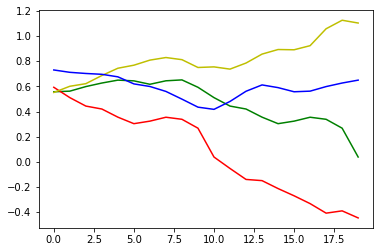

In [88]:
plt.plot(forecasts[175], 'g')
plt.plot(forecasts[184], 'r')
plt.plot(forecasts[244], 'y')
plt.plot(forecasts[160], 'b')

### Create a synthetic time sequence of 20 timesteps with high standard deviation (sudden jump)

In [89]:
t1 = np.arange(-1.0, -0.5, 0.05)
np.append(t1, 1)
len(t1)

10

In [90]:
t2 = np.arange(1.1, 1.6, 0.05)
len(t2)

10

In [91]:
final = np.concatenate((t1,t2))
final

array([-1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 ,
       -0.55,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,
        1.5 ,  1.55])

In [92]:
len(final)

20

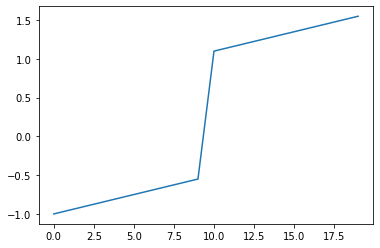

In [93]:
plt.plot(final)

In [94]:
np.std(final), np.mean(final), np.var(final)

(1.0597759197113323, 0.27500000000000024, 1.1231250000000002)

In [95]:
final = final.reshape(-1, 20, 1)

In [96]:
final_cluster = dba_km.predict(final)

In [97]:
final_cluster

array([2])

#### Compute the relative change in mean, std, var for this synthetic data point that has a sudden jump (therefore, high std).

In [98]:
mean_final =(np.mean(final) - tests_std_var['cluster_mean'][0]) / abs(tests_std_var['cluster_mean'][0])
std_final = ((np.std(final) - tests_std_var['cluster std'][0])) / abs(tests_std_var['cluster std'][0])
variance_final = ((np.var(final) - tests_std_var['cluster variance'][0])) / abs(tests_std_var['cluster variance'][0])

In [99]:
print("mean of synthetic time sequence:", mean_final)
print("std of synthetic time sequence:", std_final)
print("variance of synthetic time sequence:", variance_final)

mean of synthetic time sequence: -0.508414696544433
std of synthetic time sequence: 6.107783930291172
variance of synthetic time sequence: 49.52059417881317


### Create another time sequence with sudden fall in values

In [100]:
t2 = np.arange(1, 0.8, -0.025)
len(t2)

8

In [101]:
t2


array([1.   , 0.975, 0.95 , 0.925, 0.9  , 0.875, 0.85 , 0.825])

In [102]:
t2 = np.append(t2, -0.8)

In [103]:
t1 = np.arange(-0.75, -0.64, 0.01)
len(t1)

11

In [104]:
t1

array([-0.75, -0.74, -0.73, -0.72, -0.71, -0.7 , -0.69, -0.68, -0.67,
       -0.66, -0.65])

In [105]:
final_down = np.concatenate((t2, t1))
final_down

array([ 1.   ,  0.975,  0.95 ,  0.925,  0.9  ,  0.875,  0.85 ,  0.825,
       -0.8  , -0.75 , -0.74 , -0.73 , -0.72 , -0.71 , -0.7  , -0.69 ,
       -0.68 , -0.67 , -0.66 , -0.65 ])

In [106]:
len(final_down)

20

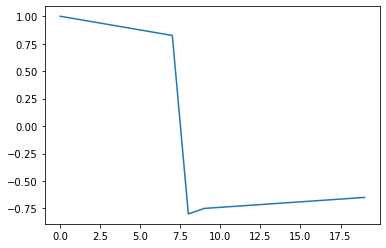

In [107]:
plt.plot(final_down)

In [108]:
final_down = final_down.reshape(-1, 20, 1)

In [109]:
final_down_cluster = dba_km.predict(final_down)
final_down_cluster

array([4])

In [110]:
cluster4_mean = np.mean(dba_km.cluster_centers_[4])
cluster4 = x_train[y_pred == 4]
cluster4 =  np.array(cluster4)

std = np.std(cluster4, axis=1)
var = np.var(cluster4, axis=1)

std = std.flatten()
var = var.flatten()

std_max_index = np.argmax(std)
std_max = std.max()

var_max_index = np.argmax(var)
var_max = var.max()


In [111]:
np.mean(final_down), cluster4_mean

(-0.06000000000000001, -0.05033888109317528)

In [112]:
mean_final_down = ((np.mean(final_down)) - cluster4_mean) / abs(cluster4_mean)
std_final_down = (np.std(final_down) - std_max) / abs(std_max)
variance_final_down = (np.var(final_down) - var_max) / abs(var_max)

In [113]:
print("mean of synthetic time sequence:", mean_final_down)
print("std of synthetic time sequence:", std_final_down)
print("variance of synthetic time sequence:", variance_final_down)

mean of synthetic time sequence: -0.1919216060631618
std of synthetic time sequence: 0.021805077864399593
variance of synthetic time sequence: 0.044085643913221895
